# COSC2753 - Machine Learning

# Introduction

In this assignment, we will be working to develop a model that can predict whether the patients will develop Sepssis or not. The dataset provided contains various information regarding the bloodwork and other measurements of the patients in ICU. This report will be using machine learning techniques learnt from week 1 to 5 to train a machine learning model using the data from 'Paitients_Files_Train.csv', and then use the model to predict the outcome using data from 'Paitients_Files_Test.csv' 

---

# Exploratory Data Analysis

The first step is to observe our dataset, analyse it and perform preprocessing methods to make the dataset suitable for machine learning models.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("./Paitients_Files_Train.csv")

In [16]:
df.head(1)

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive


The model's purpose is to predict whether the patient will develop Sepssis or not. Since the column only has 2 outcomes 'Positive' and 'Negative', we can identify that this is a binary classification problem.

Since ID and Insurance does not affect the chance of getting Sepssis, we drop these 2 columns. We will then take a look at our data to make sure there are no null values.

In [17]:
df.drop(['ID', 'Insurance'], axis='columns', inplace=True)

Since PRG, PL, PR, SK, TS, are related to blood work values, and M11 is body mass index, these values cannot be 0, meaning that the 0 in the tables are null values. We can see that except for BD2, Age, and Sepssis, all other columns have null values. There are many methods to deal with null values, such as: replacing null values with certain values, deleting the row, or deleting the columns. We will fill the columns for now and decide whether we should remove them when checking their correlation later.

We will look at the column's data distribution to identify which values we should fill in for missing values. For skewed data, we can use either median or mode of the column to fill the null values, whereas for data which has close to normal distribution, we will use mean.

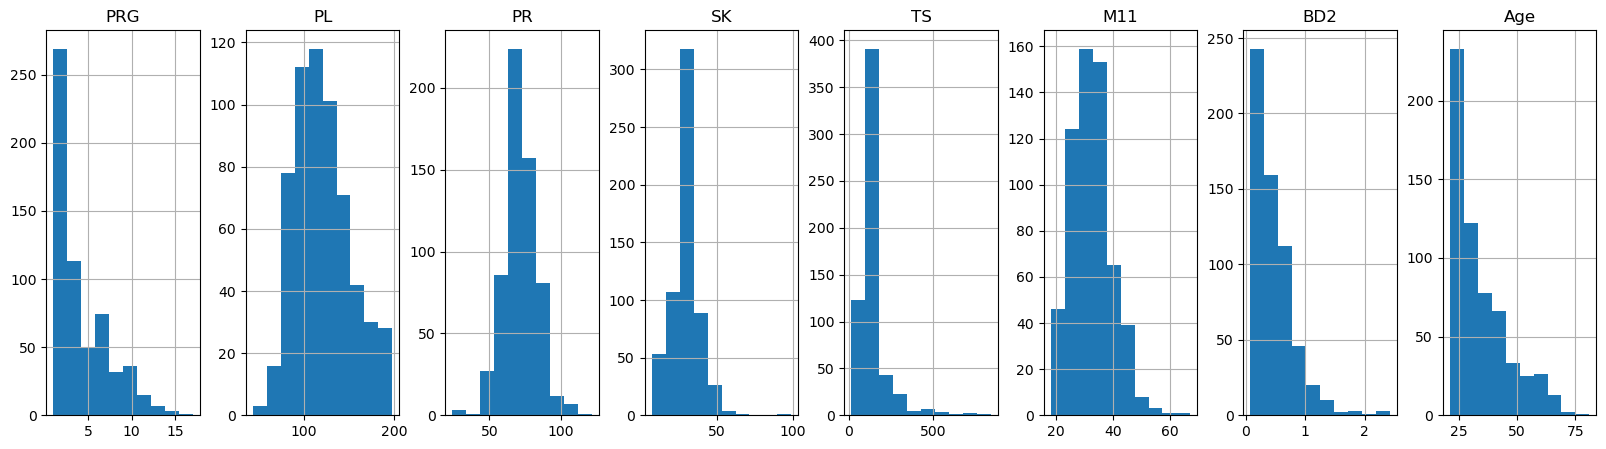

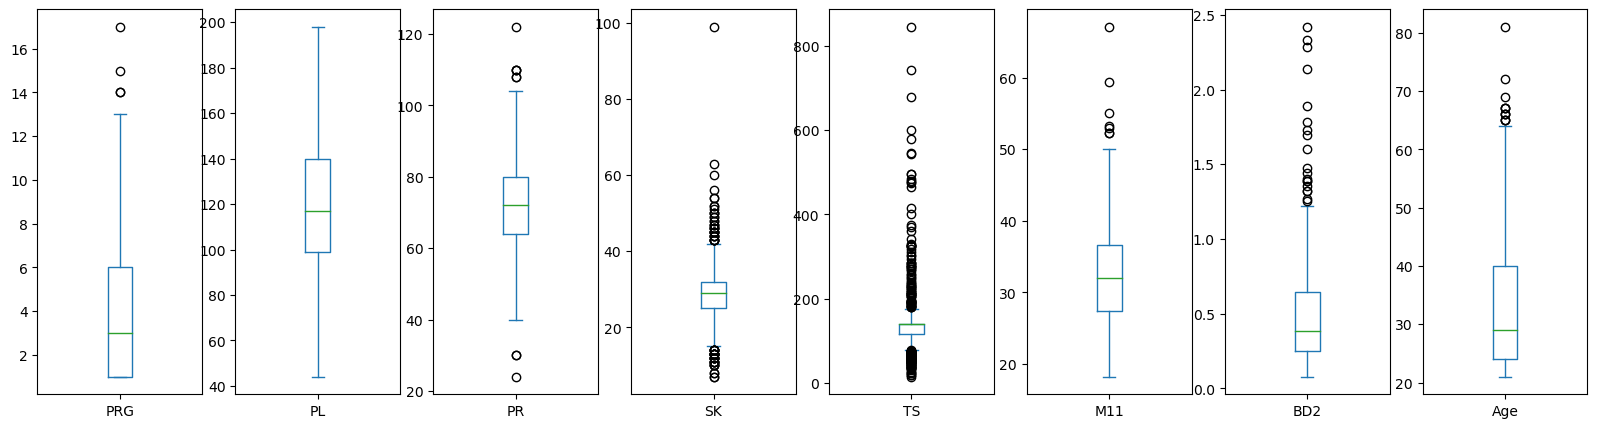

In [32]:
df.hist(figsize=(20, 5), layout=(1, 8))
plt.show()
df.plot(kind='box', subplots=True, layout=(1,8), sharex=False, sharey=False, figsize=(20, 5))
plt.show()

In [19]:
df[['PRG', 'PL', 'PR', 'SK', 'TS', 'M11']] = df[['PRG', 'PL', 'PR', 'SK', 'TS', 'M11']].replace(0, np.nan)
df['PRG'].fillna(round(df['PRG'].mode()[0]), inplace=True)
df['PL'].fillna(round(df['PL'].mean()), inplace=True)
df['PR'].fillna(round(df['PR'].mean()), inplace=True)
df['SK'].fillna(round(df['SK'].median()), inplace=True)
df['TS'].fillna(round(df['TS'].mode()[0]), inplace=True)
df['M11'].fillna(round(df['M11'].median()), inplace=True)

We now take a look at our data distribution to see if there are any changes in the shape of the distribution. 

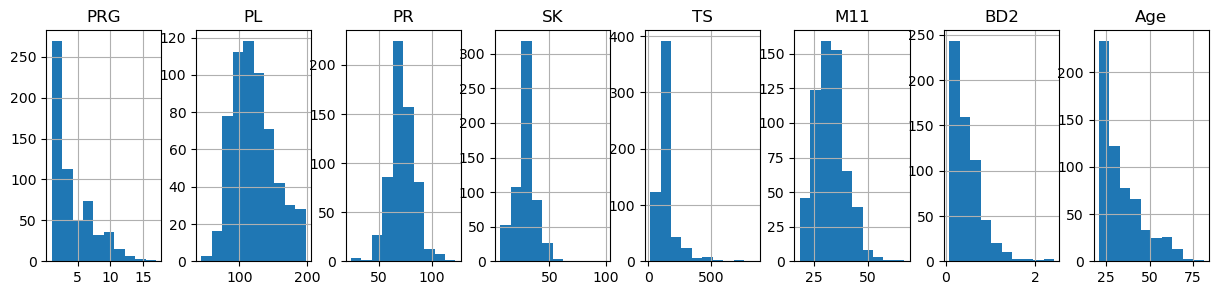

In [20]:
df.hist(figsize=(15, 3), layout=(1, 8))
plt.show()

We then look at the correlation of our data to see if any columns are related to each other, then we should drop either one and use the other column. 

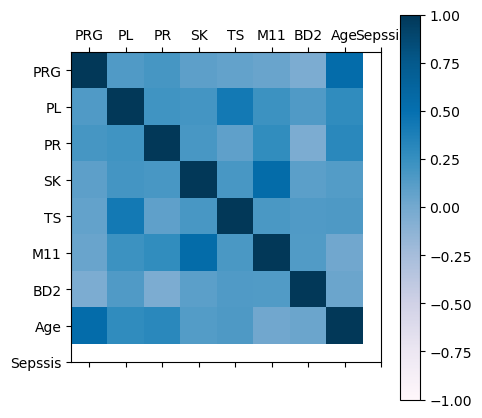

In [21]:
correlations = df.corr()
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap=plt.cm.PuBu)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

Since there isn't that much correlation between the columns, meaning all columns are independent, we don't need to drop any columns. Next, we will look into the percentage of people developing sepssis or not to identify whether our data is balanced or imbalanced.

In [22]:
print('Percentage of people developing sepssis = {}%'.format(len(df[df['Sepssis'] == 'Positive']) / len(df) * 100))

Percentage of people developing sepssis = 34.72454090150251%


This show that our data is mildly imbalanced. We can deal with this by either using a model that works well with imbalanced data, such as Decision Tree or Random Forest, or we can resample the data, either undersampling or oversampling the data to balance the class.

---

# Evaluating Models

In the next step, we will fit our train data into the machine learning models and compare the performance of each model. First, we will split our training data into a ratio of 8:2 for training and testing. Then we select a model, tune it and then cross validate it, repeats until overfitting and underfitting is minimized. After that, we will train the model using the training data and test on the test data.

There are many ways to evaluate a model. In this report, we will be focusing on f1 score, since the classes are imbalance in our data, and f1 score penalizes models that have many false negative. In the end, we will select the models based on how well the model fit the training data, how well the model perform on validation and test data, efficiency, and consistency.

---

# 1. Logistic Regression

Logistic Regression is a model that is usually used for classification problems, and is one of the most simplest approach.

Before using logistic regression, we must scale our data, since logistic regression is a gradient-based algorithm and is sensitive to the range of data point. Since some columns have outliers, we will normalize the data, using min-max scaler. 

After splitting the training and testing data, we need to perform oversampling to deal with the imbalance in the class of the train data.

In [23]:
y = df.Sepssis.copy()
x = df.drop(['Sepssis'], axis='columns')
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x, columns=['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40, shuffle=True)
sampler = SMOTE(random_state=0)
x_train_up, y_train_up = sampler.fit_resample(x_train, y_train)

## Hypertuning

We can tune parameters of a model to improve its performance, which will increase its accuracy and overfitting problems. We will be using Grid Search in our model tuning to find the model which provides best F1 validation score and save that model's parameters. For Logistic Regression, we will be focusing on tuning these parameters:

* penalty: Method of regularization. We will be using either Lasso Regression (L1) or Ridge Regression (L2)
* C: Inverse of regularization strength. If this value is too high, model will be underfitting, and if this value is too low, model will be overfitting.
* solver: Algorithm to use in the optimization problem.
* class_weight: Distribution of the class labels of the data.
* multi_class: The classification problem is either binary classification or multi-class classification. [1]

In [24]:
clf = Pipeline(steps = [['smote', SMOTE(random_state=0)], ['classification', LogisticRegression()]])
grid_param = [
    {
        'classification__penalty': ['l1', 'l2'],
        'classification__C': np.linspace(10, 100, 10, dtype=int),
        'classification__solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg', 'newton-cholesky'],
        'classification__class_weight': ['balanced', None],
        'classification__multi_class': ['ovr'],
    }
]
grid_search = GridSearchCV(estimator=clf, param_grid=grid_param, n_jobs=-1, scoring='f1_macro', cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=0)],
                                       ['classification',
                                        LogisticRegression()]]),
             n_jobs=-1,
             param_grid=[{'classification__C': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                          'classification__class_weight': ['balanced', None],
                          'classification__multi_class': ['ovr'],
                          'classification__penalty': ['l1', 'l2'],
                          'classification__solver': ['lbfgs', 'liblinear',
                                                     'sag', 'saga', 'newton-cg',
                                                     'newton-cholesky']}],
             scoring='f1_macro')

## Cross validation

Cross validation evaluates our model by splitting our training data into number of segments to used as training and validating data. We will use this method to check if our model is working properly with different split variations. If our train score is close to our validation score, the model is not overfitting. We will be using Stratified KFold for cross validation in this report.

In [25]:
logModel = grid_search.best_estimator_
f1 = cross_validate(logModel, x_train, y_train, cv=5, scoring='f1_macro', return_train_score=True, n_jobs=-1)
print("f1 train scores:", f1['train_score'])
print("f1 valid scores:", f1['test_score'])
print("average f1 train score:", f1['train_score'].mean(), "| standard deviation: ", f1['train_score'].std())
print("average f1 valid score:", f1['test_score'].mean(), "| standard deviation: ", f1['test_score'].std())

f1 train scores: [0.72260387 0.75232216 0.72500147 0.73221317 0.71981438]
f1 valid scores: [0.72831303 0.65154265 0.74952562 0.69459173 0.73684211]
average f1 train score: 0.7303910085224671 | standard deviation:  0.011711940120718311
average f1 valid score: 0.7121630261707621 | standard deviation:  0.035353707870886854


The cross validation train and test score are close to each other, meaning there is no overfitting nor underfitting. We then use the best model we got from hypertuning parameters to train our model and then test on the test set.

In [26]:
logModel.fit(x_train_up, y_train_up)
predTrain = logModel.predict(x_train)
predTest = logModel.predict(x_test)
print(logModel.get_params())
print("f1 score on train set: ", f1_score(y_train, predTrain, average='macro'))
print("f1 score on test set: ", f1_score(y_test, predTest, average='macro'))

{'memory': None, 'steps': [('smote', SMOTE(random_state=0)), ['classification', LogisticRegression(C=10, class_weight='balanced', multi_class='ovr',
                   penalty='l1', solver='liblinear')]], 'verbose': False, 'smote': SMOTE(random_state=0), 'classification': LogisticRegression(C=10, class_weight='balanced', multi_class='ovr',
                   penalty='l1', solver='liblinear'), 'smote__k_neighbors': 5, 'smote__n_jobs': None, 'smote__random_state': 0, 'smote__sampling_strategy': 'auto', 'classification__C': 10, 'classification__class_weight': 'balanced', 'classification__dual': False, 'classification__fit_intercept': True, 'classification__intercept_scaling': 1, 'classification__l1_ratio': None, 'classification__max_iter': 100, 'classification__multi_class': 'ovr', 'classification__n_jobs': None, 'classification__penalty': 'l1', 'classification__random_state': None, 'classification__solver': 'liblinear', 'classification__tol': 0.0001, 'classification__verbose': 0, 'classi

# 2. Cost-Sensitive Decision Tree

Decision tree is a flowchart-like tree structure used for classification and prediction, where an internal node shows a test on an attribute, a branch represents the test outcome, and a leaf node has a class label [2]. For decision tree, we don't need to normalize data or deal with imbalance class as these models are not sensitive to the variance in the data. Cost-sensitive decision tree (weighted decision tree) is a type of decision tree to handle data with imbalanced class.

There are 2 options for improving the decision tree: pre-tuning and post-tuning

* Pre-tuning: Stop generating sub-trees based on properties of remaining training data. Hyperparameter tuning is also a pre-tuning technique.
* Post-tuning: Remove sub-tree to avoid overfitting the data.

Since the dataset is not very large, we will be using post-tuning to optimize the decision tree. Although post-tuning is less effective than pre-tuning, post-tuning will be more precise in its prediction than the greedy method pre-tuning with smaller dataset. We will be post-pruning our decision tree using cost complexity parameter (ccp_alpha). Greater ccp_alpha means more nodes from the trees are pruned. We will select the model with the highest test f1 score from our post-tuned trees. After that we will train, cross-validate using train set and test that model against test set.

Code and scores are in appendices.

# 3. Balanced Random Forest

Random Forest is a model that combines the output of multiple decision trees to achieve one final result. It can handle classification problems better than decision tree, however, it requires more computational power. For random forest, we don't need to normalize data as it is not sensitive to the variance in the data. A balanced random forest is a random forest that randomly under-samples each boostrap sample to balance it, therefore it can deal with imbalanced class. [3]

We will also use GridSearch to hypertune the parameters of the random forest. We will tune these parameters:

* n_estimators: The number of decision trees used in a forest. This value can be lower to avoid overfitting.
* max_features: The number of features to consider when looking for best split.
* criterion: The function to measure the quality of a split.
* max_depth: The maximum depth of the decision tree generated by the random forest. This value can be limited to avoid overfitting.
* max_leaf_nodes: maximum number of nodes a decision tree can produce. This value can be limited to avoid overfitting. [4]

Code and scores are in appendices.

---
# Conclusion

After evaluating the 3 models, we can see that they all perform effectively to predict the sepssis. All models got from 0.65 to 0.85 f1 scores on the test set when trying with different random state of data split. 

Firstly, the logistic regression model converges well, resulting in small difference between training, and testing scores. Cross-validation for logistic regression also shows close average train and validation scores. This means the logistic regression model is not overfitting. However small training score and sometimes high test score suggests underfitting and availability of luck during testing. 

Secondly, the cost-sensitive decision tree got decent train scores and test scores, however, they are inconsistent. That is, the train scores can vary between 0.75 to 0.92, and the test scores can vary between 0.69 to 0.83. Cross-validation shows that the model can be overfitting sometimes.

Finally, the average train and test scores are both decent for balanced random forest model. Although being a bit overfitted compared to the logistic regression, it is normal that the train score is higher than the test score. The only drawback of random forest is its expensive to optimize the model. 

For the problem of predicting sepssis on patient, we need the most consistent and most accurate prediction, therefore we will choose the logistic regression as our final model to perform the prediction. Balanced Random Forest model has proven to be consistent with it's consistent train (77-85) and test scores (73-83) when trying with different data split, even when the test set is easy or hard to predict.

* Logistic Regression: lowest training scores and close to validation score, small underfitting, scores higher on test set than other models ~50% of the time.
* Decision Tree: inconsistent training scores, most overfitting, inconsistent scores on test set (can be fluctuate from highest to lowest compared to other models) depends on how train-test data is split.
* Random Forest: high training scores and decent validation scores, moderate overfitting depends on the GridSearch hypertuning, scores higher than logistic regression 30% of the time and the rest are lower.

---

# Appendices

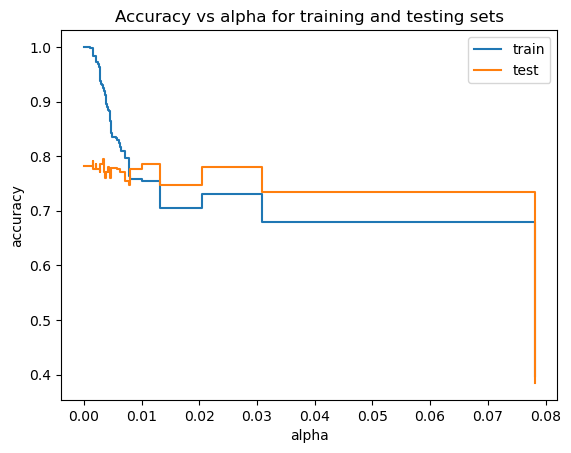

f1 train scores: [0.94902396 0.96009467 0.965681   0.97430392 0.95489649]
f1 valid scores: [0.5758806  0.61321515 0.6998557  0.60750361 0.63809524]
average f1 train score: 0.9608000084435444 | standard deviation:  0.008720140794875576
average f1 valid score: 0.6269100583085598 | standard deviation:  0.04150744911292181
{'ccp_alpha': 0.00334513152552062, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}
f1 score on train set:  0.9250657754390955
f1 score on test set:  0.7942857142857143


In [27]:
y = df.Sepssis.copy()
x = df.drop(['Sepssis'], axis='columns')

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40, shuffle=True)
weights = {'Negative': 0.66, 'Positive': 0.34 [ [321321 ]]}

clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0, class_weight='balanced')
    clf.fit(x_train, y_train)
    clfs.append(clf)
    
train_scores = []
test_scores = []
for clf in clfs:
    predTrain = clf.predict(x_train)
    predTest = clf.predict(x_test)
    train_scores.append(f1_score(y_train, predTrain, average='macro'))
    test_scores.append(f1_score(y_test, predTest, average='macro'))   
    
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, label="test", drawstyle="steps-post")
ax.legend()
plt.show()

dtModel = DecisionTreeClassifier()
for i in range(len(clfs)):
    if test_scores[i] == max(test_scores):
        dtModel.set_params(**clfs[i].get_params())
        
# Cross validation score
f1 = cross_validate(dtModel, x_train, y_train, cv=5, scoring='f1_macro', return_train_score=True, n_jobs=-1)
print("f1 train scores:", f1['train_score'])
print("f1 valid scores:", f1['test_score'])
print("average f1 train score:", f1['train_score'].mean(), "| standard deviation: ", f1['train_score'].std())
print("average f1 valid score:", f1['test_score'].mean(), "| standard deviation: ", f1['test_score'].std())

# Prediction test
dtModel.fit(x_train, y_train)
predTrain = dtModel.predict(x_train)
predTest = dtModel.predict(x_test)
print(dtModel.get_params())
print("f1 score on train set: ", f1_score(y_train, predTrain, average='macro'))
print("f1 score on test set: ", f1_score(y_test, predTest, average='macro'))

<center> 1. Code and graph visualization for decision tree training, cross validating and testing </center>

In [28]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(random_state=0)
grid_param = [
    {
        'n_estimators': [50, 75, 100],
        'max_features': ['log2', 'sqrt'],
        'criterion' :['gini', 'entropy'],
        'max_depth' : np.linspace(5, 15, 11, dtype=int),
        'max_leaf_nodes': np.linspace(10, 20, 11, dtype=int),
    }
]
grid_search = GridSearchCV(estimator=clf, param_grid=grid_param, n_jobs=-1, scoring='f1_macro', cv=5)
grid_search.fit(x_train, y_train)

# Cross Validation
rfModel = grid_search.best_estimator_
f1 = cross_validate(rfModel, x_train, y_train, cv=5, scoring='f1_macro', return_train_score=True, n_jobs=-1)
print("f1 train scores:", f1['train_score'])
print("f1 valid scores:", f1['test_score'])
print("average f1 train score:", f1['train_score'].mean(), "| standard deviation: ", f1['train_score'].std())
print("average f1 valid score:", f1['test_score'].mean(), "| standard deviation: ", f1['test_score'].std())

# Prediction test
rfModel.fit(x_train, y_train)
predTrain = rfModel.predict(x_train)
predTest = rfModel.predict(x_test)
print(rfModel.get_params())
print("f1 score on train set: ", f1_score(y_train, predTrain, average='macro'))
print("f1 score on test set: ", f1_score(y_test, predTest, average='macro'))

f1 train scores: [0.81666131 0.84163566 0.81034239 0.81666131 0.81488203]
f1 valid scores: [0.79765808 0.64021164 0.79506641 0.75266047 0.73100011]
average f1 train score: 0.8200365385273833 | standard deviation:  0.01104401818975493
average f1 valid score: 0.7433193430009386 | standard deviation:  0.057446803281911374
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 13, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}
f1 score on train set:  0.8073773488338086
f1 score on test set:  0.7794117647058825


<center> 2. Code for random forest training, cross validating and testing </center>

---

# Reference

[1] “Sklearn.linear_model.logisticregression,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. [Accessed: 07-Apr-2023]. 

[2] “Decision tree,” GeeksforGeeks, 28-Mar-2023. [Online]. Available: https://www.geeksforgeeks.org/decision-tree/. [Accessed: 07-Apr-2023]. 

[3] “Balancedrandomforestclassifier#,” imbalanced-learn. [Online]. Available: https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html. [Accessed: 09-Apr-2023]. 

[4] “Sklearn.ensemble.randomforestclassifier,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. [Accessed: 07-Apr-2023]. 